In [8]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import os
import sys

import numpy.random as rnd

import tensorflow as tf

In [2]:
# 设置随机种子，让结果复现
def reset_graph(seed=42):
    tf.reset_default_graph() # 重置网络
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
# 配置画图参数
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_ROOT_DIR = '../'

def save_fig(CHAPTED_ID, fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR ,'images',CHAPTED_ID, fig_id+'.png')
    print('saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [14]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')

In [5]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()
    w, h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows + pad, (h+pad)*n_cols + pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h), (x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmp='Greys', interpolation='nearest')
    plt.axis("off")

创建3D数据

In [6]:
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

标准化数据（针对列）

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.fit_transform(data[100:])

# PCA with a linear Autoencoder

自编码机autoencoder

In [14]:

reset_graph() # 前面定义的函数
n_inputs = 3
n_hidden = 2
n_outputs = n_inputs  # 自编码，输入和输出的维度是相同的，只是换了一种表达方式
learning_rate = 0.01

# None表示样本的数量，可以不写，n_inputs数据的唯独

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)


reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))  # 输出与输入的损失
# 优化器
optimizer = tf.train.AdamOptimizer(learning_rate)
# 最小化损失函数
training_op = optimizer.minimize(reconstruction_loss)

# 初始化所有变量
init = tf.global_variables_initializer()


In [16]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train})
    # coding_val是hidden层在验证集的输出， eval()是评价函数  
    coding_val = codings.eval(feed_dict={X: X_test})

saving figure linear_autoencoding_pac_plot


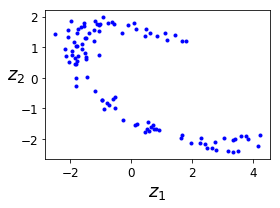

In [20]:
fig = plt.figure(figsize=(4,3))
plt.plot(coding_val[:, 0], coding_val[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
save_fig("autoencoders","linear_autoencoding_pac_plot")
plt.show()

# Stacked Autoencoders

# 堆自编码机

数据集
http://yann.lecun.com/exdb/mnist/

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../DataCollecct/mnist")

reset_graph()
from functools import partial

Extracting ../../DataCollecct/mnist/train-images-idx3-ubyte.gz
Extracting ../../DataCollecct/mnist/train-labels-idx1-ubyte.gz
Extracting ../../DataCollecct/mnist/t10k-images-idx3-ubyte.gz
Extracting ../../DataCollecct/mnist/t10k-labels-idx1-ubyte.gz


In [10]:
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# 构建一个编码层
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,                  # 属于全链接层
                        activation=tf.nn.elu,              # 激活函数 
                        kernel_initializer=he_init,        # 初始化层的核
                        kernel_regularizer=l2_regularizer  # 核的正则化
                        )

# 多个层堆叠起来称堆自编码，而上面只有一个隐藏层
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

# 损失函数
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
# l2正则化部分
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
# 将上面两个部分链接起来，组成真正的损失函数
loss = tf.add_n([reconstruction_loss] + reg_losses )

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [11]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

09% Train MSE: 0.0206423
19% Train MSE: 0.0113829
29% Train MSE: 0.0102241
3 Train MSE: 0.00990069
4 Train MSE: 0.010377


In [15]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
saving figure reconstruction_plot


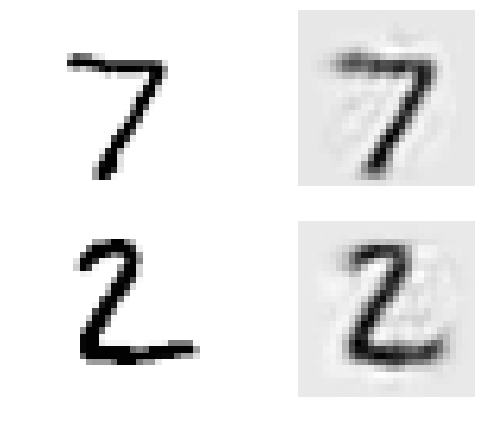

In [17]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("autoencoders", "reconstruction_plot")

# 加权的堆自编码机

在不同编码机层，添加不同的权重

In [18]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [19]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)



In [20]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

09% Train MSE: 0.0150669
1 Train MSE: 0.0164887
2 Train MSE: 0.0173759
3 Train MSE: 0.0168783
4 Train MSE: 0.0155877


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


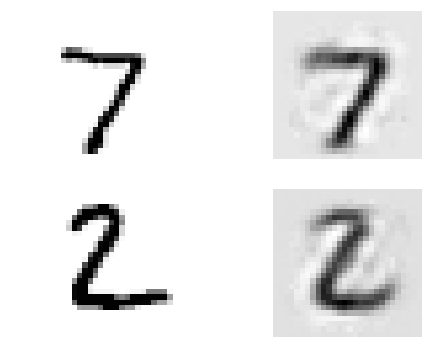

In [21]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")